In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from scipy.spatial import Delaunay

from src.depth import DepthPoset
from src.density import SquareDensity, TriangulationDensity

# SquareDensity

## Density  Functions and their Integrals

In [3]:
dens0 = SquareDensity.from_rectangles([0.2, 0.5, 0.7, 0.6], [0.3, 0.6, 0.9, 0.9], [0.4, 0.7, 0.7, 0.3], [0.5, 0.8, 0.9, 0.5])
dens1 = SquareDensity.from_rectangles([0.1], [0.8], [0.2], [0.8])

dens2 = dens0 + dens1
dens3 = abs(dens0 - dens1)

denses = [dens0, dens1, dens2, dens3]
dens_labels = ['dens0', 'dens1', 'dens0 + dens1', '|dens0 - dens1|']

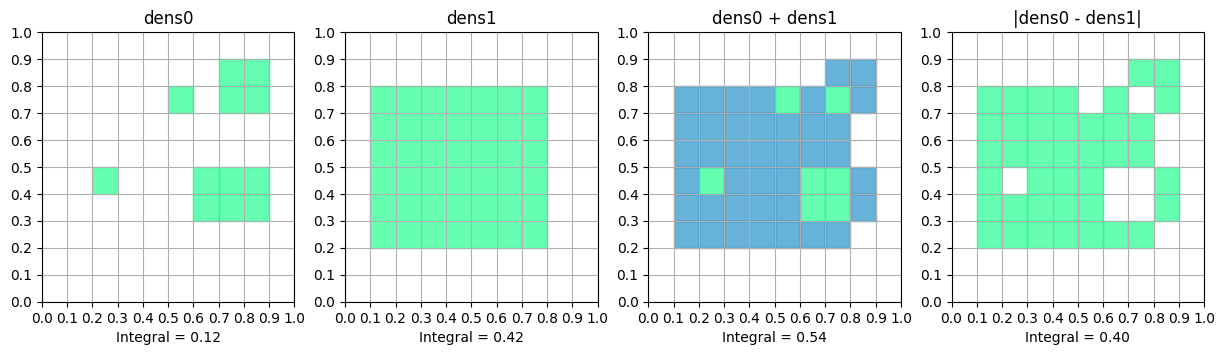

In [4]:
fig, axs = plt.subplots(1, len(denses))
fig.set_figheight(3.5)
fig.set_figwidth(15)

for i, dens in enumerate(denses):
    axs[i].set_title(dens_labels[i])
    dens.show(cmap='winter', alpha=0.6, ax=axs[i])
    
    axs[i].set_xticks(np.linspace(0, 1, 11))
    axs[i].set_yticks(np.linspace(0, 1, 11))
    axs[i].grid(True)
    
    axs[i].text(0.5, -0.15, f"Integral = {dens.integral():.2f}", ha='center', transform=axs[i].transAxes)
        
plt.show(fig)

## Density (proximity) Functions of Depth Posets and the Distance

### Simplicial complex

In [5]:
points = np.random.random([18, 2])
triangles = Delaunay(points)

filtrations = list(np.random.random(size=[2, triangles.nsimplex]))
for i in range(1):
    filtrations.append(filtrations[1] + 0.1*(np.random.random(size=filtrations[1].shape) - 0.5))

strees = []
for filtration in filtrations:
    stree = gh.SimplexTree()
    for simplex, filtration_value in zip(triangles.simplices, filtration):
        stree.insert(simplex, filtration_value)
    strees.append(stree)

depth_posets = [DepthPoset.from_simplex_tree(stree) for stree in strees]

denses = [SquareDensity.from_depth_poset(dp) for dp in depth_posets]

/home/feodor/Jupyter/depth-poset/src/density.py:67: RuntimeWarning: invalid value encountered in add
  x_mid = 0.5*(x[1:] + x[:-1])
/home/feodor/Jupyter/depth-poset/src/density.py:68: RuntimeWarning: invalid value encountered in add
  y_mid = 0.5*(y[1:] + y[:-1])


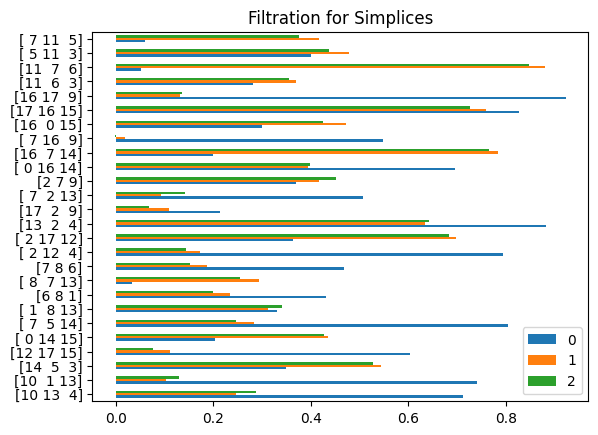

In [6]:
pd.DataFrame(filtrations, columns=[str(i) for i in triangles.simplices]).transpose().plot(kind='barh')
plt.title('Filtration for Simplices')
plt.show()

/home/feodor/Jupyter/depth-poset/src/density.py:202: RuntimeWarning: invalid value encountered in add
  x_mid, y_mid = np.meshgrid(0.5*(x[1:] + x[:-1]), 0.5*(y[1:] + y[:-1]))
/home/feodor/Jupyter/depth-poset/src/density.py:178: RuntimeWarning: invalid value encountered in scalar add
  xval, yval = 0.5*(x0 + x1), 0.5*(y0 + y1)


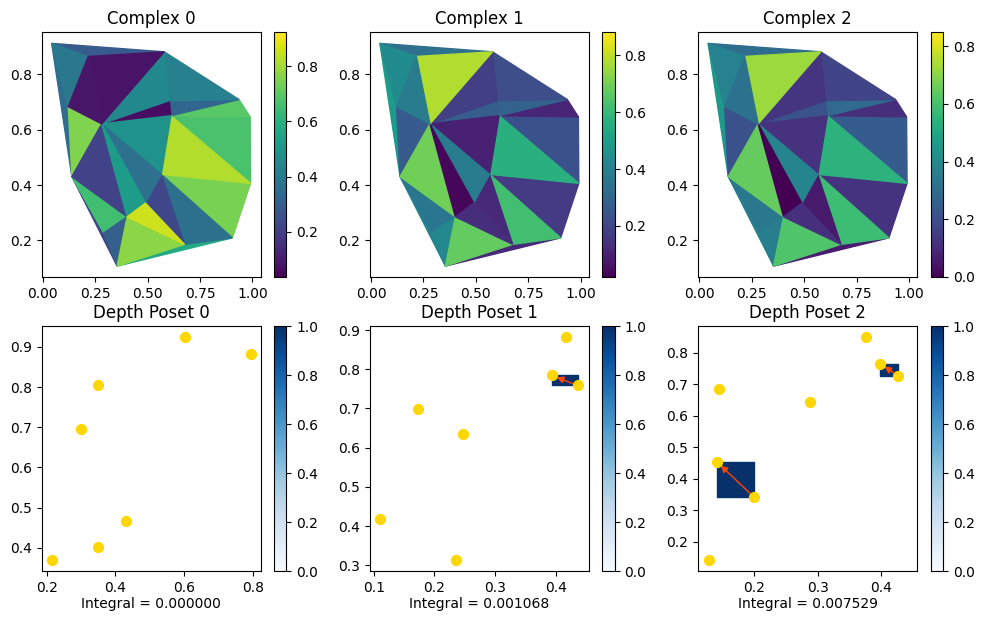

In [7]:
fig, axs = plt.subplots(2, len(filtrations))
fig.set_figheight(7)
fig.set_figwidth(12)

# Draw simplices and their filtration
cmap = plt.get_cmap('viridis')
for i, filtration in enumerate(filtrations):
    axs[0, i].set_title(f'Complex {i}')
    for filter_value, simplex in zip(filtration, triangles.simplices):
        x, y = points[simplex].transpose()
        axs[0, i].fill(x, y, color=cmap(filter_value))
    norm = Normalize(vmin=np.min(filtration), vmax=np.max(filtration))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[0, i])

for i, (dp, dens) in enumerate(zip(depth_posets, denses)):
    axs[1, i].set_title(f'Depth Poset {i}')
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[1, i], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    axs[1, i].text(0.5, -0.15, f"Integral = {dens.integral():.6f}", ha='center', transform=axs[1, i].transAxes)
    
    sm = dens.show(cmap='Blues', alpha=1, ax=axs[1, i], zorder=0)
    cbar = plt.colorbar(sm, ax=axs[1, i])
    

In [8]:
def density_distance(dp0: DepthPoset, dp1: DepthPoset, p: float=1) -> float:
    """
    """
    return (abs(SquareDensity.from_depth_poset(dp0) - SquareDensity.from_depth_poset(dp1))**p).integral()**(1/p)

/home/feodor/Jupyter/depth-poset/src/density.py:117: RuntimeWarning: invalid value encountered in add
  x_grid = 0.5*(x[1:] + x[:-1])
/home/feodor/Jupyter/depth-poset/src/density.py:118: RuntimeWarning: invalid value encountered in add
  y_grid = 0.5*(y[1:] + y[:-1])
/home/feodor/Jupyter/depth-poset/src/density.py:67: RuntimeWarning: invalid value encountered in add
  x_mid = 0.5*(x[1:] + x[:-1])
/home/feodor/Jupyter/depth-poset/src/density.py:68: RuntimeWarning: invalid value encountered in add
  y_mid = 0.5*(y[1:] + y[:-1])


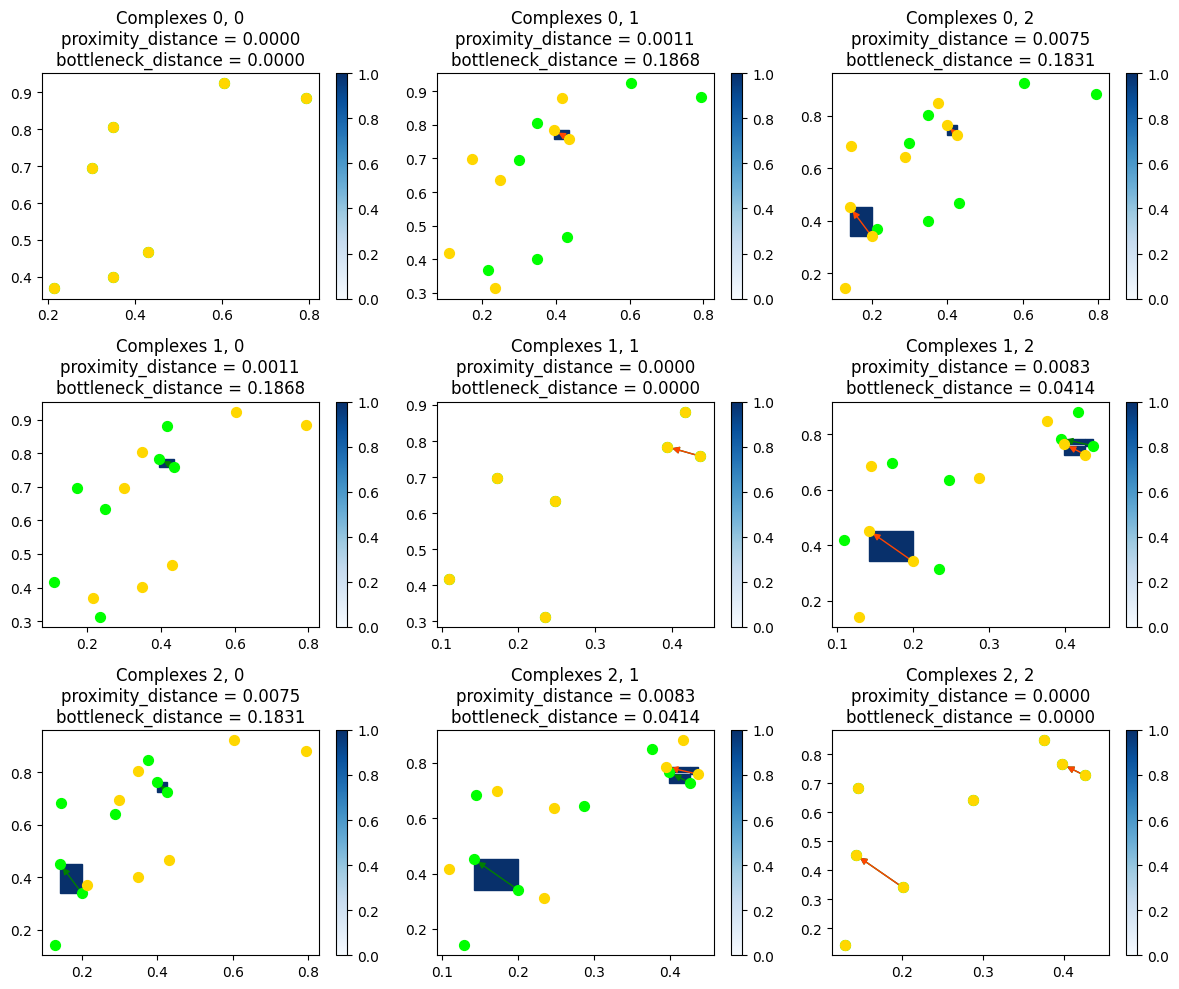

In [9]:
fig, axs = plt.subplots(len(depth_posets), len(depth_posets))
fig.set_figheight(10)
fig.set_figwidth(12)

for i, j in itertools.product(np.arange(len(depth_posets)), repeat=2):
    dp0, dp1 = depth_posets[i], depth_posets[j]
    stree0, stree1 = strees[i], strees[j]
    diag0, diag1 = stree0.persistence(), stree1.persistence()
    diag0 = [i[1] for i in diag0]
    diag1 = [i[1] for i in diag1]
    
    nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.persistant_layout(), ax=axs[i, j], 
                     node_size=50, node_color='lime', edge_color='green', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.persistant_layout(), ax=axs[i, j], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    dens = abs(denses[i] - denses[j])
    
    sm = dens.show(cmap='Blues', alpha=1, ax=axs[i, j], zorder=0)
    cbar = plt.colorbar(sm, ax=axs[i, j])
    
    annotation = f"Complexes {i}, {j}\n"
    annotation += f"proximity_distance = {density_distance(dp0, dp1):.4f}\n"
    annotation += f"bottleneck_distance = {gh.bottleneck_distance(diag0, diag1):.4f}"
    axs[i, j].set_title(annotation)
plt.tight_layout()

### Michals case

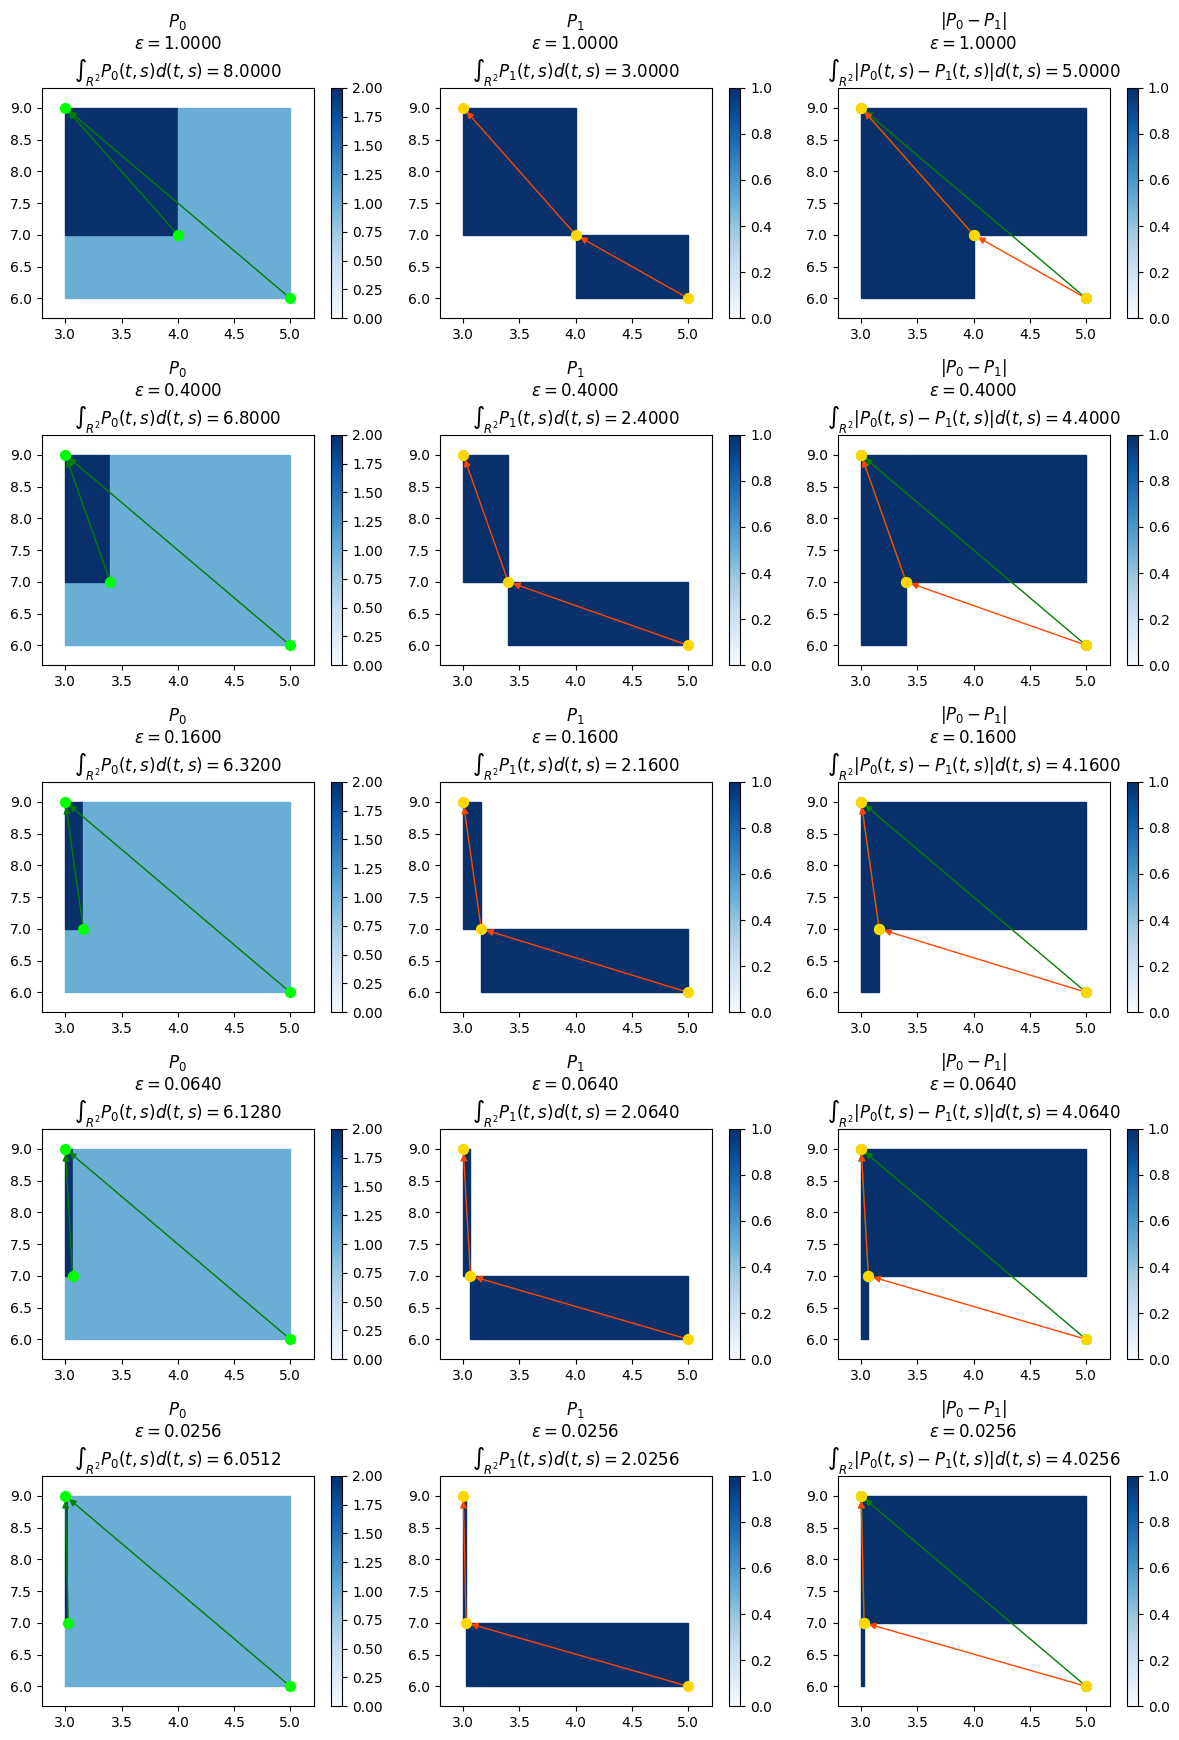

In [10]:
eps_values = 0.4**np.arange(5)


fig, axs = plt.subplots(len(eps_values), 3)
fig.set_figheight(3.5*len(eps_values))
fig.set_figwidth(12)

for i_eps, eps in enumerate(eps_values):
    
    filtration0 = {(0,): 1, 
                   (1,): 3, 
                   (2,): 3 + eps, 
                   (3,): 5, 
                   (0, 1): 9, 
                   (2, 1): 7, 
                   (3, 1): 6}
    filtration1 = {(0,): 1, 
                   (1,): 3 + eps, 
                   (2,): 3, 
                   (3,): 5, 
                   (0, 1): 9, 
                   (2, 1): 7, 
                   (3, 1): 6}
    
    stree0 = gh.SimplexTree()
    for key, value in filtration0.items():
        stree0.insert(key, filtration=value)
    stree1 = gh.SimplexTree()
    for key, value in filtration1.items():
        stree1.insert(key, filtration=value)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)
    
    dens0 = SquareDensity.from_depth_poset(dp0)
    dens1 = SquareDensity.from_depth_poset(dp1)
    dens2 = abs(dens0 - dens1)

    sm0 = dens0.show(ax=axs[i_eps, 0])
    sm1 = dens1.show(ax=axs[i_eps, 1])
    sm2 = dens2.show(ax=axs[i_eps, 2])

    nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.persistant_layout(), ax=axs[i_eps, 0], 
                     node_size=50, node_color='lime', edge_color='green', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.persistant_layout(), ax=axs[i_eps, 1], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.persistant_layout(), ax=axs[i_eps, 2], 
                     node_size=50, node_color='lime', edge_color='green', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.persistant_layout(), ax=axs[i_eps, 2], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    
    plt.colorbar(sm0, ax=axs[i_eps, 0])
    plt.colorbar(sm1, ax=axs[i_eps, 1])
    plt.colorbar(sm2, ax=axs[i_eps, 2])

    axs[i_eps, 0].set_title(f'$P_0$\n$\\epsilon={eps:.4f}$\n$\\int_{{R^2}} P_0(t, s) d(t, s) = {dens0.integral():.4f}$')
    axs[i_eps, 1].set_title(f'$P_1$\n$\\epsilon={eps:.4f}$\n$\\int_{{R^2}} P_1(t, s) d(t, s) = {dens1.integral():.4f}$')
    axs[i_eps, 2].set_title(f'$|P_0 - P_1|$\n$\\epsilon={eps:.4f}$\n$\\int_{{R^2}} |P_0(t, s) - P_1(t, s)|d(t, s) = {dens2.integral():.4f}$')
plt.tight_layout()

plt.show()

__Conclusion:__ The transposition can change not only 4 simplices in transposed pairs, and the distance does not catch this situations and this is not stable.

# TriangulationDensity

## TriangulationDensity methods

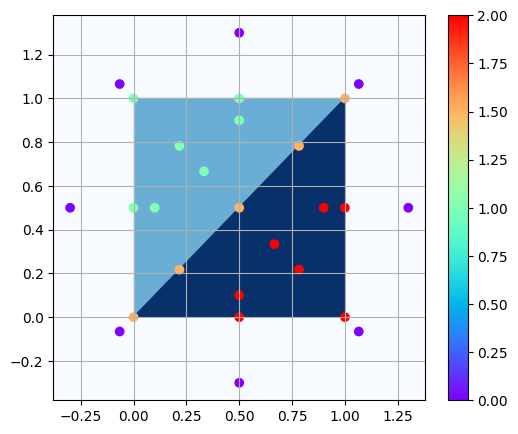

In [11]:
vertices = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
triangles = np.array([[0, 1, 2], [0, 2, 3]])
values = np.array([1, 2])

tridens = TriangulationDensity(vertices, triangles, values)

n = 8
points = np.concatenate([vertices, 
                         vertices[triangles[:, [0, 1]]].mean(axis=1), 
                         vertices[triangles[:, [0, 2]]].mean(axis=1), 
                         vertices[triangles[:, [1, 2]]].mean(axis=1), 
                         vertices[triangles].mean(axis=1), 
                         0.8*np.array([np.cos(2*np.pi*np.arange(n)/n), 
                                       np.sin(2*np.pi*np.arange(n)/n)]).transpose() + 0.5*np.ones(2),
                         0.4*np.array([np.cos(2*np.pi*np.arange(n)/n), 
                                       np.sin(2*np.pi*np.arange(n)/n)]).transpose() + 0.5*np.ones(2),
                        ])
points = np.round(points, 12)
points = np.unique(points, axis=0)

point_values = tridens(points[:, 0], points[:, 1])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sm_tri = tridens.show(ax=ax)

cmap = plt.get_cmap('rainbow')
norm = Normalize(vmin=np.min(point_values), vmax=np.max(point_values))
ax.scatter(points[:, 0], points[:, 1], color=cmap(norm(point_values)))
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)

plt.grid(True)
plt.show()

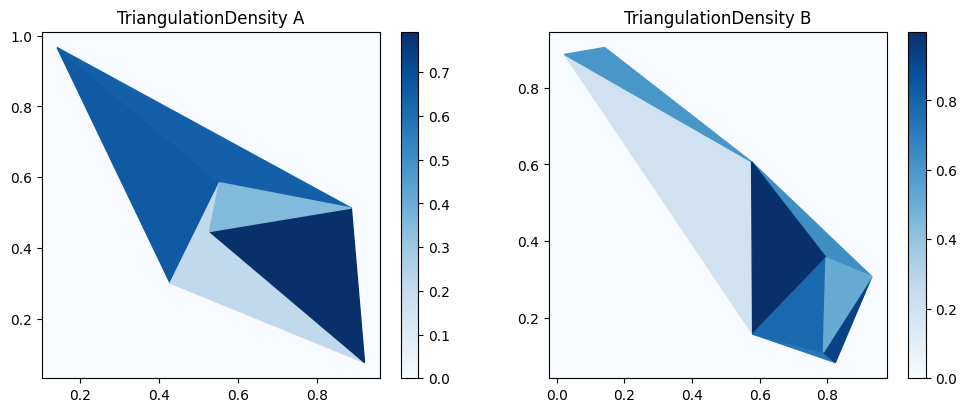

In [12]:
n0 = 6
n1 = 8

vertices0 = np.random.random([n0, 2])
vertices1 = np.random.random([n1, 2])

tri0 = Delaunay(vertices0).simplices
tri1 = Delaunay(vertices1).simplices

values0 = np.random.random(len(tri0))
values1 = np.random.random(len(tri1))

tridens0 = TriangulationDensity(vertices0, tri0, values0)
tridens1 = TriangulationDensity(vertices1, tri1, values1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

axs[0].set_title('TriangulationDensity A')
axs[1].set_title('TriangulationDensity B')

sm0 = tridens0.show(ax=axs[0])
sm1 = tridens1.show(ax=axs[1])
cbar0 = plt.colorbar(sm0, ax=axs[0])
cbar1 = plt.colorbar(sm1, ax=axs[1])

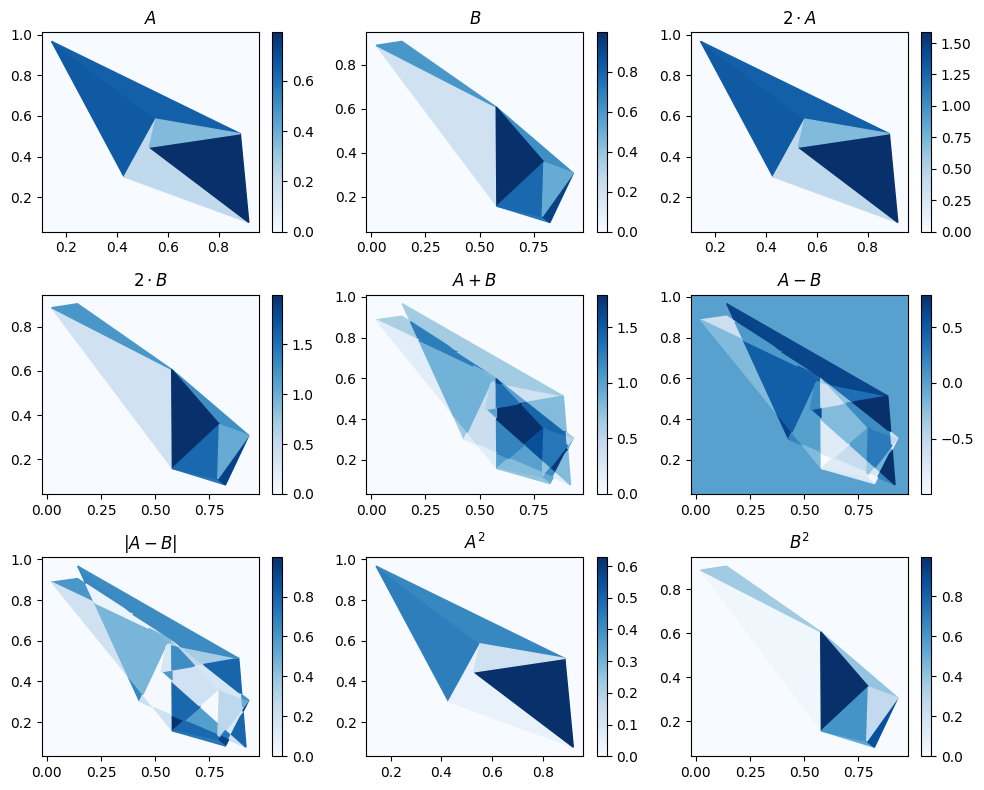

In [13]:
operations = {r'$A$': lambda a, b: a,
              r'$B$': lambda a, b: b,
              r'$2\cdot A$': lambda a, b: a*2,
              r'$2\cdot B$': lambda a, b: b*2,
              r'$A + B$': lambda a, b: a + b, 
              r'$A - B$': lambda a, b: a - b, 
              r'$|A - B|$': lambda a, b: abs(a - b), 
              r'$A^2$': lambda a, b: a**2,
              r'$B^2$': lambda a, b: b**2,
}

fig, axs = plt.subplots(3, 3, figsize=(10, 8))
for i, (key, operation) in enumerate(operations.items()):
    axs[i//3, i%3].set_title(key)
    
    tridensi = operation(tridens0, tridens1)
    smi = tridensi.show(ax=axs[i//3, i%3])
    cbari = plt.colorbar(smi, ax=axs[i//3, i%3])

plt.tight_layout()
plt.show()

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: divide by zero encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: divide by zero encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2


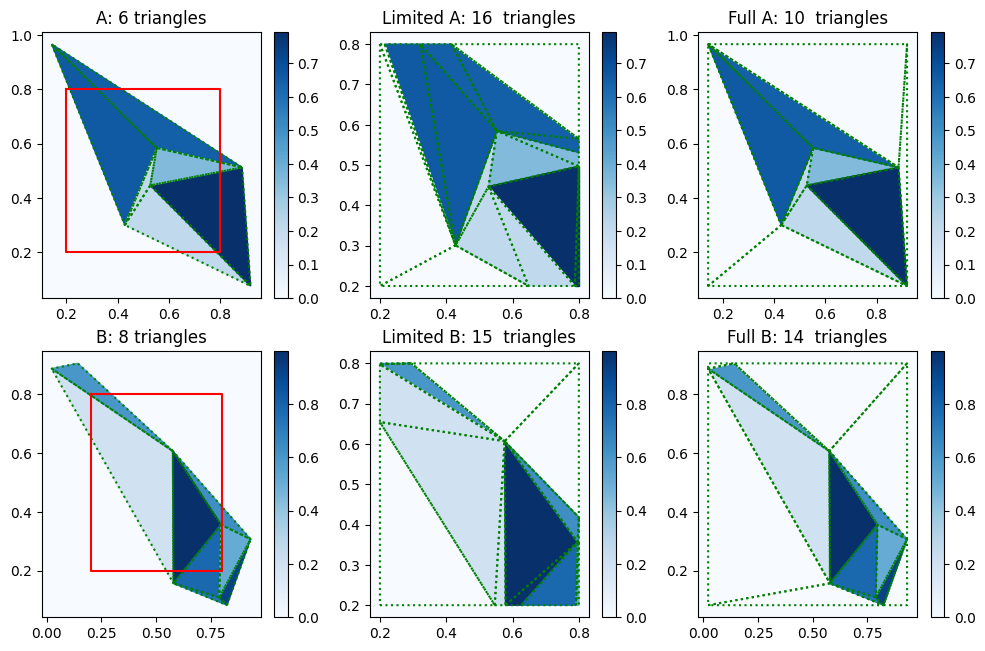

In [14]:
xmin, xmax = 0.2, 0.8
ymin, ymax = 0.2, 0.8

tridenss = {'A': tridens0, 
            'B': tridens1}

fig, axs = plt.subplots(len(tridenss), 3, figsize=(12, 3.8*len(tridenss)))

for i, (key, tridensi) in enumerate(tridenss.items()):
    axs[i, 0].set_title(f'{key}: {len(tridensi.triangles)} triangles')
    smi = tridensi.show(ax=axs[i, 0])
    cbari = plt.colorbar(smi, ax=axs[i, 0])
    for triangle in tridensi.triangles:
        triangle_points = tridensi.vertices[np.append(triangle, triangle[0])]
        axs[i, 0].plot(triangle_points[:, 0], triangle_points[:, 1], color='green', linestyle=':')
    axs[i, 0].plot([xmin, xmax, xmax, xmin, xmin], [ymax, ymax, ymin, ymin, ymax], color='red')
    
    tridensi_cuted = tridensi.get_subsquare(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    axs[i, 1].set_title(f'Limited {key}: {len(tridensi_cuted.triangles)}  triangles')
    smi = tridensi_cuted.show(ax=axs[i, 1])
    cbari = plt.colorbar(smi, ax=axs[i, 1])
    for triangle in tridensi_cuted.triangles:
        triangle_points = tridensi_cuted.vertices[np.append(triangle, triangle[0])]
        axs[i, 1].plot(triangle_points[:, 0], triangle_points[:, 1], color='green', linestyle=':')
        
    tridensi_cuted = tridensi.get_subsquare(xmin=-np.inf, xmax=+np.inf, ymin=-np.inf, ymax=+np.inf)
    axs[i, 2].set_title(f'Full {key}: {len(tridensi_cuted.triangles)}  triangles')
    smi = tridensi_cuted.show(ax=axs[i, 2])
    cbari = plt.colorbar(smi, ax=axs[i, 2])
    for triangle in tridensi_cuted.triangles:
        triangle_points = tridensi_cuted.vertices[np.append(triangle, triangle[0])]
        axs[i, 2].plot(triangle_points[:, 0], triangle_points[:, 1], color='green', linestyle=':')

plt.show(fig)

In [15]:
tridenss = {'A': tridens0, 
            'B': tridens1, 
            'A+B': tridens0 + tridens1, 
            'A-B': tridens0 - tridens1, 
            'B-A': tridens1 - tridens0, 
            '1': TriangulationDensity([[0, 0], [0, 1], [1, 1]], [[0, 1, 2]], [1], 1)
           }
limits = [(-np.inf, +np.inf, -np.inf, +np.inf), 
          (0.2, 0.8, 0.2, 0.8)]

pd.DataFrame({tridens_key: {limit_values: tridens_object.integral(*limit_values) for limit_values in limits} for tridens_key, tridens_object in tridenss.items()})

,,,,A,B,A+B,A-B,B-A,1
-inf,inf,-inf,inf,0.168313,0.129484,0.297797,0.038828,-0.038828,inf
0.2,0.8,0.2,0.8,0.124434,0.090984,0.215418,0.033450,-0.033450,0.36


## Distance

In [16]:
points = np.random.random([24, 2])
triangles = Delaunay(points)

filtrations = list(np.random.random(size=[2, triangles.nsimplex]))
for i in range(1):
    filtrations.append(filtrations[1] + 0.1*(np.random.random(size=filtrations[1].shape) - 0.5))

strees = []
for filtration in filtrations:
    stree = gh.SimplexTree()
    for simplex, filtration_value in zip(triangles.simplices, filtration):
        stree.insert(simplex, filtration_value)
    strees.append(stree)

depth_posets = [DepthPoset.from_simplex_tree(stree) for stree in strees]

denses = [SquareDensity.from_depth_poset(dp) for dp in depth_posets]

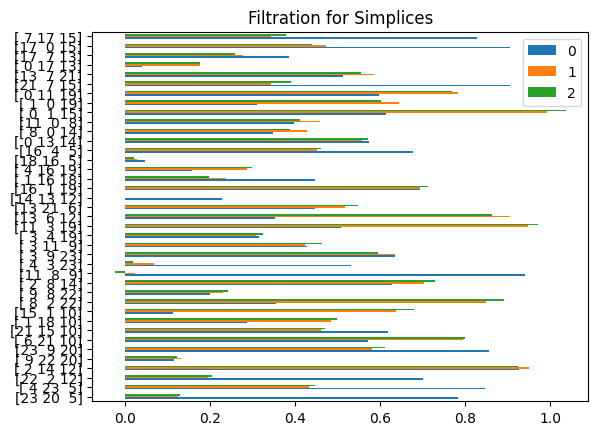

In [17]:
pd.DataFrame(filtrations, columns=[str(i) for i in triangles.simplices]).transpose().plot(kind='barh')
plt.title('Filtration for Simplices')
plt.show()

In [18]:
def get_dp_density(dp: DepthPoset, edge_radius_dict):
    # 
    pos = dp.persistant_layout()
    edge_densities = []
    for edge in dp.edges:
        p0 = np.array(pos[edge[0]])
        p1 = np.array(pos[edge[1]])
        r = edge_radius_dict[edge]

        vertices = np.array([p0 + np.array([r, -r]), p0 + np.array([r, r]), p0 + np.array([-r, -r]), 
                             p1 + np.array([-r, r]), p1 + np.array([-r, -r]), p1 + np.array([r, r])])
        triangles = np.array([[0, 1, 2], [3, 4, 5], [1, 2, 5], [2, 4, 5]])
        values = np.ones(4)
        #l = r*(p1 - p0)/np.linalg.norm(p1 - p0)
        #n = np.array([l[1], -l[0]])
        #vertices = np.array([p1 + l + n, p1 + l - n, p0 - l + n, p0 - l - n])
        #triangles = np.array([[0, 1, 2], [1, 2, 3]])
        #values = np.ones(2)

        edge_densities.append(TriangulationDensity(vertices, triangles, values))

    if len(edge_densities) == 0:
        result_density = TriangulationDensity([[1, 0], [0.5, 0], [1, 0.5]], [[0, 1, 2]], [0], 0)
    else: 
        result_density = edge_densities[0]
    for i in range(1, len(edge_densities)):
        result_density = result_density + edge_densities[i]
    return result_density

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: divide by zero encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: invalid value encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: divide by zero encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: invalid value encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:90: RuntimeWarning: divide by zero encountered in divide
  v = (d11 * d20 - d01 * d21) / denom#[:, np.newaxis]  # (n_p, n_tri)
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:90: RuntimeWarning: invalid value encountered in divide
  v = (d11 * d20 - d01 * d21) / denom#[:, np.newaxis]  # (n_p, n_tri)
/home/feodor/Jupyter/depth-poset/src/pl

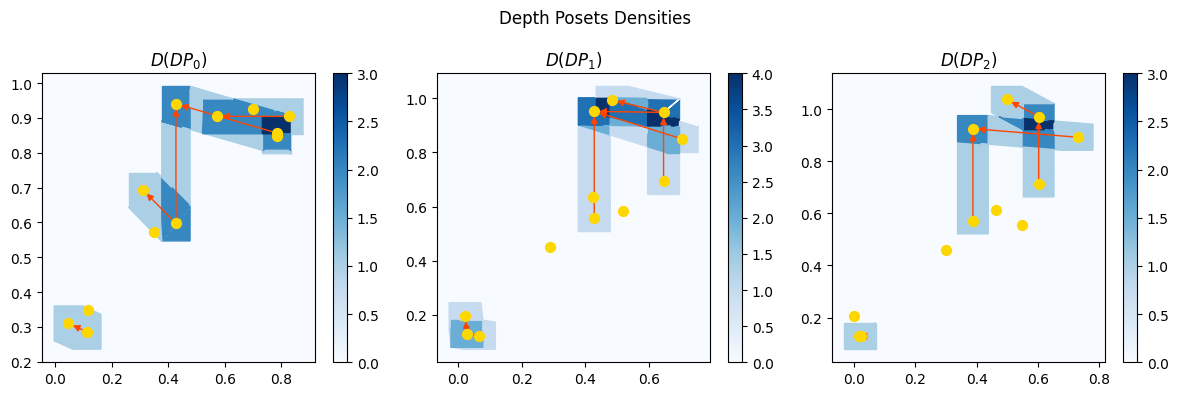

In [19]:
fig, axs = plt.subplots(1, len(depth_posets), figsize=(12, 4))
fig.suptitle('Depth Posets Densities')

dp_densities = []

for i, dp in enumerate(depth_posets):
    axs[i].set_title(f'$D(DP_{{{i}}})$')
    
    edge_radius_dict = {edge: 0.05 for edge in dp.edges}

    dp_density = get_dp_density(dp, edge_radius_dict)
    dp_densities.append(dp_density)

    sm = dp_density.show(ax=axs[i])
    plt.colorbar(sm, ax=axs[i])
    #for triangle in dp_density.triangles:
    #    triangle_points = dp_density.vertices[np.append(triangle, triangle[0])]
    #    axs[i].plot(triangle_points[:, 0], triangle_points[:, 1], color='green', linestyle=':')
            
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[i], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)

plt.tight_layout()
plt.show()

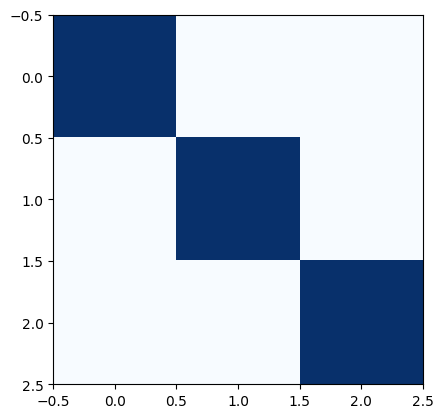

In [20]:
plt.imshow([[i == j for i in dp_densities] for j in dp_densities], cmap='Blues')

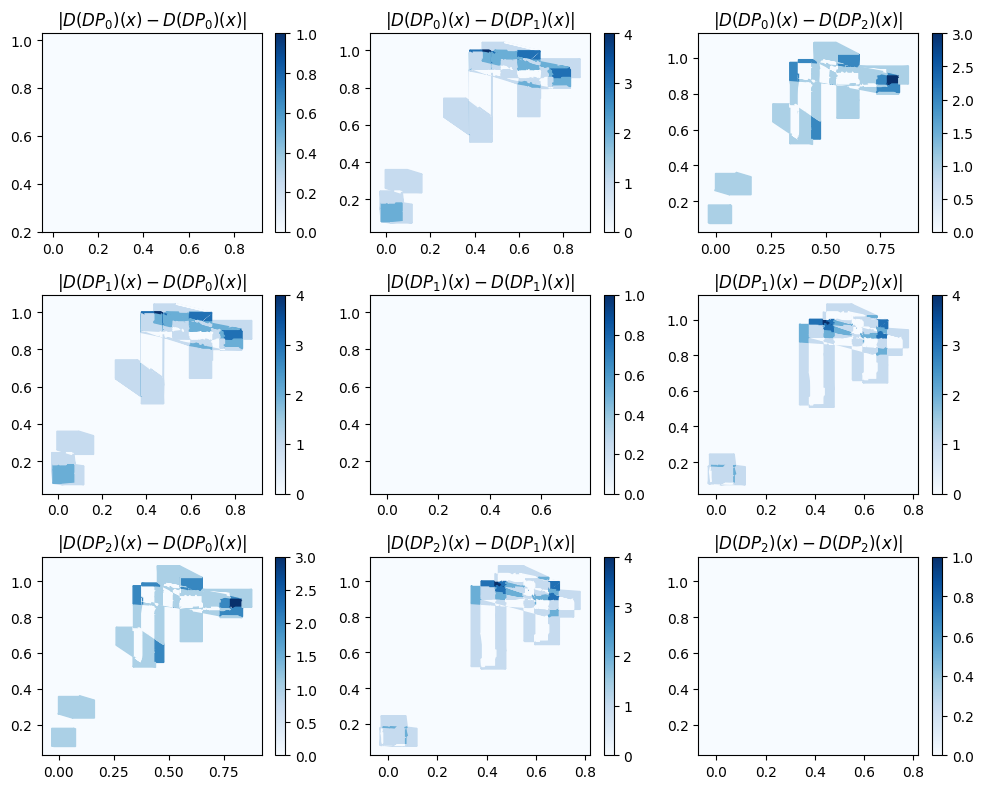

In [21]:
fig, axs = plt.subplots(len(dp_densities), len(dp_densities), figsize=(10, 8))

for i, (i0, i1) in enumerate(itertools.product(range(len(dp_densities)), repeat=2)):
    irow, i_col = i//axs.shape[1], i%axs.shape[1]
    axs[irow, i_col].set_title(f'$|D(DP_{{{i0}}})(x) - D(DP_{{{i1}}})(x)|$')
    
    diff_density = abs(dp_densities[i0] - dp_densities[i1])
    
    sm = diff_density.show(ax=axs[irow, i_col])
    plt.colorbar(sm, ax=axs[irow, i_col])
    
plt.tight_layout()
plt.show()

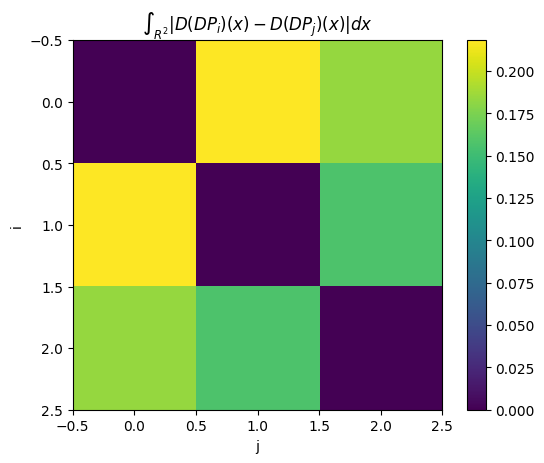

In [22]:
diff_integrals = np.nan*np.zeros([len(dp_densities), len(dp_densities)])

for i, j in itertools.product(range(len(dp_densities)), repeat=2):
    diff_density = abs(dp_densities[i] - dp_densities[j])
    diff_density_integral = diff_density.integral()
    diff_integrals[i, j] = diff_density_integral

plt.title(r'$\int_{R^2} |D(DP_i)(x) - D(DP_j)(x)|dx$')
sm = plt.imshow(diff_integrals)
plt.colorbar(sm)
plt.xlabel('j')
plt.ylabel('i')
plt.show()